# Check list
1. 기존 시뮬레이션 방법 확인
2. Avg dtheta, theta사용해서 위치 확인하는것 확인
3. Avg dtheta 빠르게 구하는 방법

In [87]:
from parfor import parfor
import TO_sim.Integrator_jit as IJ
from TO_sim.Kuramoto_model import Kuramoto_2nd_mf,Kuramoto_1st_mf
from TO_sim.Q_simul import Q_Normal, Q_Lorentz
import numpy as np, matplotlib.pyplot as plt
from TO_sim.get_cluster import cluster_os_new2
import pandas as pd
RK4_jit_short = IJ.RK4_short

In [7]:
func = Kuramoto_2nd_mf

In [97]:
def assign_group_by_tolerance(df, tolerance):
    group_number = 0
    current_group_start = df['group abs rot'][0]  # 첫번째 값이 그룹의 시작 기준
    # 첫번째 값에 그룹 번호 할당
    df.at[0, 'Group'] = group_number
    
    # 두번째 값부터 확인하면서 그룹을 할당
    for i in range(1, len(df)):
        # 현재 값이 그룹 시작 값으로부터 tolerance 안에 있으면 같은 그룹으로 묶음
        if df['group abs rot'][i] - current_group_start <= tolerance:
            df.at[i, 'Group'] = group_number
        else:
            # 그룹 시작 값보다 tolerance를 벗어나면 새로운 그룹을 할당
            group_number += 1
            current_group_start = df['group abs rot'][i]  # 새로운 그룹 시작 값 갱신
            df.at[i, 'Group'] = group_number

    return df

def Get_Group(theta,t,L):
    th = (theta[-1]-theta[-L])//(np.pi*2)
    rs = np.abs(np.mean(np.exp(1j*theta[-L:]),axis=1))
    r = np.mean(rs)
    rstd = np.std(rs)
    th = th/(t[-1] - t[-L])
    bins = np.arange(-3-0.05,3,0.1)
    c,b = np.histogram(th,bins=bins)
    # c,b = np.histogram(th,bins=bins)
    c_sort = np.sort(c)[::-1]
    c_arg = np.argsort(c)[::-1]
    c_3, = np.where(c_sort>np.max(c)*(0.03))
    b_n0 = b[c_arg[c_3]]
    db = b[1] - b[0]

    N = len(theta[-1])
    gs = {}
    gs['group #'] = []
    gs['group rot'] = []
    gs['group idx'] = []
    if r>1/np.sqrt(N):
        num = 0
        for b_l in b_n0:
            if num == 0:
                idx, = np.where((th>=2*b_l)&(th<=b_l+2*db))
                gs['group idx'].append(idx)
                gs['group rot'].append(np.mean(th[idx])*(np.pi*2))
                gs['group #'].append(len(idx))
                num += 1
            else:
                idx, = np.where((th>=b_l)&(th<=b_l+db))
                gs['group idx'].append(idx)
                gs['group rot'].append(np.mean(th[idx])*(np.pi*2))
                gs['group #'].append(len(idx))
    df =  pd.DataFrame(gs)
    try:
        df['group abs rot'] = (df['group rot']-(df['group rot'].iloc[0]+df['group rot'].iloc[1])/2).apply(lambda x: np.abs(x))
        # if abs(df['group rot'].iloc[0])<0.3:
        df['group abs rot'] = (df['group rot']-(df['group rot'].iloc[0])).apply(lambda x: np.abs(x))
        # else:
            # df['group abs rot'] = (df['group rot']-(df['group rot'].iloc[0]+df['group rot'].iloc[1])/2).apply(lambda x: np.abs(x))
    except IndexError:
        df = pd.DataFrame()
        df[['group #','group rot','Group','g sign','r_m','r_std']] = None 
        columns = df.columns
        dat = [[N,None,'T',0,r,rstd]]
        df_S = pd.DataFrame(dat,columns=columns)
        df = pd.concat([df,df_S],axis=0)
        return df
    df = df.sort_values(by='group abs rot').reset_index(drop=True)
    df = assign_group_by_tolerance(df,0.1)
    def S_rho(x):
        L = len(x)
        a = theta[-L:,x]
        ST = np.sum(np.exp(a*1j),axis=1)
        rho = np.abs(ST/L)
        return rho
    df['rho_s'] = df['group idx'].apply(S_rho)
    df['r_m'] = df['rho_s'].apply(np.mean) * df['group #']/N
    df['r_std'] = df['rho_s'].apply(np.std) * df['group #']/N
    df['g sign'] = np.sign(df['group rot']) * np.sign(df['group abs rot'])
    df = df[['group #','group rot','Group','g sign','r_m','r_std']]
    columns = df.columns
    dat = [[N,None,'T',0,r,rstd]]
    df_S = pd.DataFrame(dat,columns=columns)
    df = pd.concat([df,df_S],axis=0)
    return df

In [319]:
Ks = np.linspace(0,15,30)

In [180]:
Ks[11]

5.689655172413794

In [320]:
seed =10
N = 5000
theta_random,omega,Kc = Q_Lorentz(N,0,1,seed=seed)

omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 4.5
dt = 0.1
t = np.arange(0,5000,dt)
K = 5.5
L = 5000
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
# theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)
# plt.plot(np.sort(avg_dtheta[-1]))
# plt.plot((avg_dtheta[-1]))
Theta = np.r_[theta_random,omega]
Ks = np.arange(0,10,0.2)

In [300]:
sol = RK4_jit_short(func,Theta,t, args=(omega, N, m, K),result_time=int(t[-2000]/dt))

In [270]:
theta = sol[:,:N]

(-200.0, 200.0)

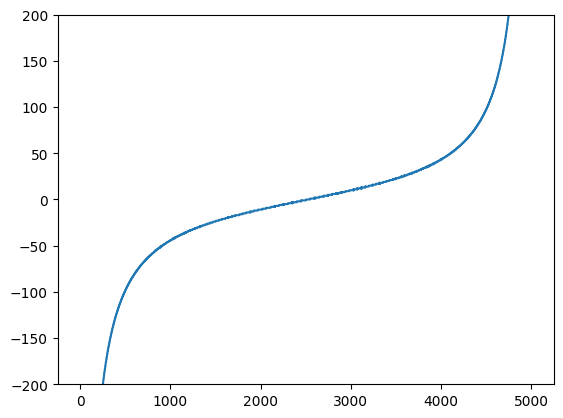

In [271]:
plt.plot((theta[-1]-theta[0])//(np.pi*2))
plt.ylim(-200,200)

In [215]:
bins = np.linspace(-100,100,1000)

In [321]:
Ks = np.linspace(0,15,31)

In [322]:
@parfor(Ks,bar=True)
def K_r(K):
    sol = RK4_jit_short(func,Theta,t, args=(omega, N, m, K),result_time=int(t[-6000]/dt))
    theta = sol[:,:N]
    df = Get_Group(theta,t,L=N)
    return df

  0%|          | 0/31 [00:00<?, ?it/s]

In [304]:
Ks

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ,
       5.2, 5.4, 5.6, 5.8, 6. , 6.2, 6.4, 6.6, 6.8, 7. , 7.2, 7.4, 7.6,
       7.8, 8. , 8.2, 8.4, 8.6, 8.8, 9. , 9.2, 9.4, 9.6, 9.8])

In [325]:
Ks = np.round(Ks,2)
df_r = pd.DataFrame(index=np.round(Ks,2))
df_r[['rT','rTstd','0p','0m','0','1p','1m','2p','2m','3p','3m']] = None
for a,(K) in zip(K_r,Ks):
    df_r.loc[K,'rT'] = a[a['Group']=='T']['r_m'].values[0]
    df_r.loc[K,'rTstd'] = a[a['Group']=='T']['r_std'].values[0]
    for i in range(4):
        try:
            df_r.loc[K,f'{i}'] = a[(a['Group']==i)&(a['g sign']==0)]['r_m'].values[0]
        except:pass
        try:
            # print(a[(a['Group']==i)&(a['g sign']==1)]['r_m'].values[0])
            df_r.loc[K,f'{i}p'] = a[(a['Group']==i)&(a['g sign']==1)]['r_m'].values[0]
            df_r.loc[K,f'{i}m'] = a[(a['Group']==i)&(a['g sign']==-1)]['r_m'].values[0]
        except:pass



In [303]:
ROT = (theta[-1] - theta[0])//(2*np.pi) /(t[-6000] *0.1) * np.pi*2

In [221]:
mean_dtheta = np.array([np.mean(dtheta[i:i+2000],axis=0) for i in range(10)])
# mean_dtheta2 = np.mean(dtheta[1:],axis=0)

In [206]:
from TO_sim.Get_2ndR_NORM import get_r_rp
from TO_sim.Get_2ndR_Lorentzian import get_r_rp as get_r_rN

In [317]:
m  = 4.5
# F_r = get_r_rp(m,0)
F_rN = get_r_rN(m,0,K_max=15)

/Users/kimgug-young/Desktop/KURAMOTO 1st order/Kuramoto-model/TO_sim/Get_2ndR_Lorentzian.py:157: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I_l,err = quad(integrand_Rl2, shift_O,+omega_p,args=(X,O_pm,shift_O,m),limit=200)
/Users/kimgug-young/Desktop/KURAMOTO 1st order/Kuramoto-model/TO_sim/Get_2ndR_Lorentzian.py:158: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I_d,err = quad(integrand_Rd2, omega_p,np.inf,args=(X,O_pm,shift_O,m),limit=200)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in F_sec (vectorized)
  outputs = ufunc(*inputs)


Text(0.5, 1.0, 'm = 4.5')

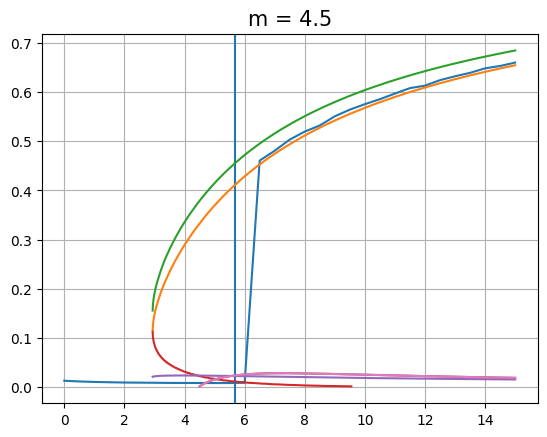

In [326]:

# DD.plot(style='.-')
plt.plot(df_r['rT'])
plt.grid()
plt.axvline(5.69)
Ks_ = F_rN['Ks']
plt.plot(K_,F_rN['R_u'](K_))
plt.plot(K_,F_rN['R0_u'](K_))
plt.plot(K_,F_rN['R_d'](K_))

plt.plot(K_,(F_rN['R0_u'](K_)-F_rN['R_u'](K_))/2)

plt.plot(Ks_,F_rN['r_+u'])
plt.plot(Ks_,F_rN['r_+u'])
# plt.plot(Ks,r_su_l,'r-')
# plt.plot(Ks,r_su_l*2)

plt.title(f'm = {m}',fontsize=15)

In [208]:
K_ = np.linspace(0,15,5000)

In [291]:
sorted_df = df_r[['0p','0m','0','1p','1m','2p','2m','3p','3m']].fillna(0).apply(lambda row: sorted(row)[::-1], axis=1, result_type='expand')

/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_93853/3377626384.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sorted_df = df_r[['0p','0m','0','1p','1m','2p','2m','3p','3m']].fillna(0).apply(lambda row: sorted(row)[::-1], axis=1, result_type='expand')


In [294]:
DD = sorted_df.replace(0,np.nan)

<Axes: >

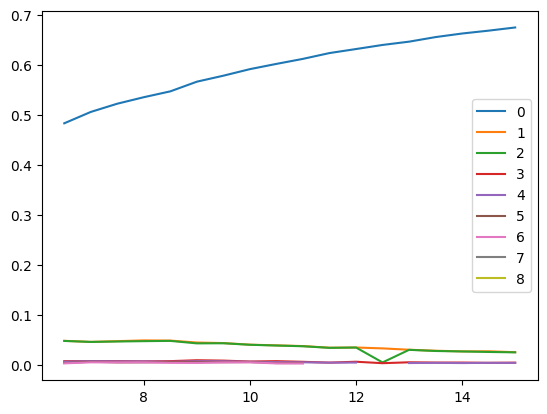

In [297]:
DD.plot()

Text(0.5, 1.0, 'm = 4.5')

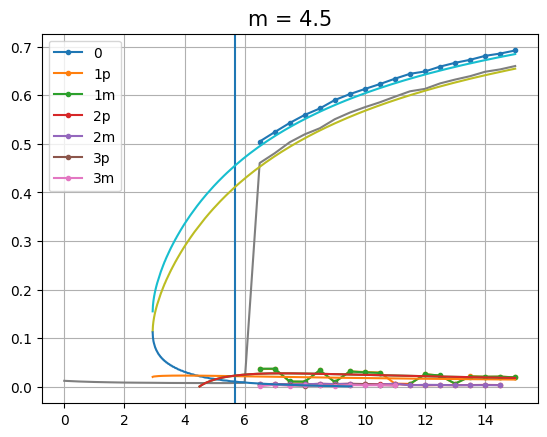

In [327]:
df_r[['0p','0m','0','1p','1m','2p','2m','3p','3m']].plot(style='.-')
# DD.plot(style='.-')
plt.plot(df_r['rT'])
plt.grid()
plt.axvline(5.69)
Ks_ = F_rN['Ks']
plt.plot(K_,F_rN['R_u'](K_))
plt.plot(K_,F_rN['R0_u'](K_))
plt.plot(K_,F_rN['R_d'](K_))

plt.plot(K_,(F_rN['R0_u'](K_)-F_rN['R_u'](K_))/2)

plt.plot(Ks_,F_rN['r_+u'])
plt.plot(Ks_,F_rN['r_+u'])
# plt.plot(Ks,r_su_l,'r-')
# plt.plot(Ks,r_su_l*2)

plt.title(f'm = {m}',fontsize=15)

In [115]:
df_R = pd.DataFrame(F_rN['r_+u'],index=Ks)

In [116]:
df_R.loc[K]

0    0.076376
Name: 7.0, dtype: float64